In [185]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [186]:
# 超参设置
max_T = 100               # RNN 输入的最大时间步长
learning_rate = 0.001     # 初始学习率
num_epochs = 20           # 训练回数
train_batch_size = 1      #每批处理的训练集数据
test_batch_size = 1       #每批处理的测试集数据

In [187]:
# 生成数据集
def Generator_data(m,max_T):
    dataset = []
    for i in range(m):
        T = np.random.randint(low=2,high=(max_T+1))
        x = np.random.rand(T)
        mask = np.zeros(T)
        mask[0] = 1
        mask[1] = 1
        np.random.shuffle(mask)
        X = np.vstack((x,mask))
        y = 0
        for i in range(T):
            if (mask[i] == 1):
                y += x[i]
        dataset.append([X,y])
    return dataset

In [188]:
train_dataset = Generator_data(10000,max_T)     #生成训练集
test_dataset = Generator_data(1000,max_T)       #生成测试集

In [189]:
train_dataset[0][0].shape, train_dataset[-1][0].shape

((2, 75), (2, 10))

In [190]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=2,
            hidden_size=32,  # RNN隐藏神经元个数
            num_layers=1,    # RNN隐藏层个数
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h):
        # x (time_step, batch_size, input_size)
        # h (n_layers, batch, hidden_size)
        # out (time_step, batch_size, hidden_size)
        out, h = self.rnn(x, h)
        prediction = self.out(out)
        return prediction, h

In [191]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rnn = RNN()
rnn = rnn.to(device)
print(rnn)

RNN(
  (rnn): RNN(2, 32)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [192]:
optimizer = torch.optim.Adam(rnn.parameters(),lr=learning_rate)
criterion = nn.MSELoss()
h_state = None  # 初始化隐藏层

In [193]:
train_loss = []     #训练集损失
test_loss = []      #测试集损失
train_error = []    #训练集相对误差
test_error = []     #测试集相对误差

In [194]:
for epoch in range(num_epochs):
    rnn.train()
    for i in range(len(train_dataset)):
        T = train_dataset[i][0].shape[1]
        input = torch.from_numpy(train_dataset[i][0]).T.view(T,train_batch_size,2) # 尺寸大小为(time_step, batch, input_size)
        label = torch.tensor(train_dataset[i][1]).view(1,1)
        input, label = input.to(device), label.to(device)
        prediction, h_state = rnn(input.float(),h_state) # RNN输出（预测结果，隐藏状态）
        h_state = h_state.detach()  # 将每一次输出的中间状态传递下去(不带梯度)
        y_pred = torch.sum(prediction).view(1,1) #对T个输出求和作为模型预测结果
        loss = criterion(y_pred, label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    rnn.eval()
    with torch.no_grad(): 
        running_loss = 0.0
        running_error = 0.0
        for i in range(len(train_dataset)):
            T = train_dataset[i][0].shape[1]
            input = torch.from_numpy(train_dataset[i][0]).T.view(T,train_batch_size,2) # 尺寸大小为(time_step, batch, input_size)
            label = torch.tensor(train_dataset[i][1]).view(1,1)
            input, label = input.to(device), label.to(device)
            prediction, h_state = rnn(input.float(),h_state) # RNN输出（预测结果，隐藏状态）
            h_state = h_state.detach()  # 将每一次输出的中间状态传递下去(不带梯度)
            y_pred = torch.sum(prediction).view(1,1)
            loss = criterion(y_pred, label.float())
            running_loss += loss.item()
            running_error += float(abs((y_pred-label)/label))
        train_loss.append(running_loss/len(train_dataset))
        train_error.append(running_error/len(train_dataset))
        print("epoch:%d train loss:%.4f train error:%.4f" % (epoch, running_loss/len(train_dataset), running_error/len(train_dataset)))

    rnn.eval()
    with torch.no_grad(): 
        running_loss = 0.0
        running_error = 0.0
        for i in range(len(test_dataset)):
            T = test_dataset[i][0].shape[1]
            input = torch.from_numpy(test_dataset[i][0]).T.view(T,test_batch_size,2) # 尺寸大小为(time_step, batch, input_size)
            label = torch.tensor(test_dataset[i][1]).view(1,1)
            input, label = input.to(device), label.to(device)
            prediction, h_state = rnn(input.float(),h_state) # RNN输出（预测结果，隐藏状态）
            h_state = h_state.detach()  # 将每一次输出的中间状态传递下去(不带梯度)
            y_pred = torch.sum(prediction).view(1,1) 
            loss = criterion(y_pred, label.float())
            running_loss += loss.item()
            running_error += float(abs((y_pred-label)/label))
        test_loss.append(running_loss/len(test_dataset))
        test_error.append(running_error/len(test_dataset))
        print("epoch:%d test loss:%.4f test error:%.4f" % (epoch, running_loss/len(test_dataset), running_error/len(test_dataset)))
        

epoch:0 train loss:0.0924 train error:0.4289
epoch:0 test loss:0.0877 test error:0.4064
epoch:1 train loss:0.0455 train error:0.2884
epoch:1 test loss:0.0427 test error:0.2913
epoch:2 train loss:0.0275 train error:0.2171
epoch:2 test loss:0.0255 test error:0.2126
epoch:3 train loss:0.0213 train error:0.1759
epoch:3 test loss:0.0203 test error:0.1722
epoch:4 train loss:0.0178 train error:0.1474
epoch:4 test loss:0.0171 test error:0.1414
epoch:5 train loss:0.0145 train error:0.1431
epoch:5 test loss:0.0138 test error:0.1386
epoch:6 train loss:0.0130 train error:0.1447
epoch:6 test loss:0.0123 test error:0.1413
epoch:7 train loss:0.0106 train error:0.1341
epoch:7 test loss:0.0102 test error:0.1326
epoch:8 train loss:0.0104 train error:0.1317
epoch:8 test loss:0.0103 test error:0.1327
epoch:9 train loss:0.0101 train error:0.1053
epoch:9 test loss:0.0097 test error:0.0972
epoch:10 train loss:0.0117 train error:0.1415
epoch:10 test loss:0.0120 test error:0.1403
epoch:11 train loss:0.0041 tra

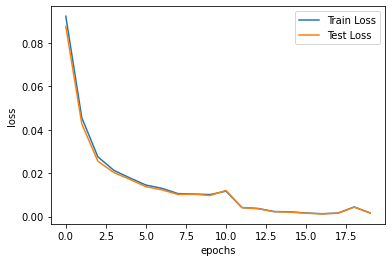

In [195]:
# 损失函数曲线
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(len(train_loss)), train_loss)
plt.plot(np.arange(len(test_loss)), test_loss)
plt.legend(['Train Loss','Test Loss'])

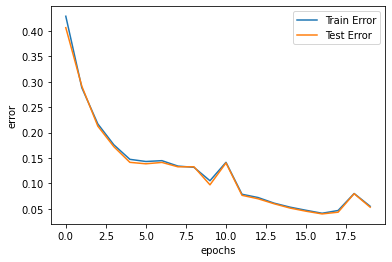

In [196]:
# 误差曲线
plt.xlabel('epochs')
plt.ylabel('error')
plt.plot(np.arange(len(train_error)), train_error)
plt.plot(np.arange(len(test_error)), test_error)
plt.legend(['Train Error','Test Error'])

In [198]:
print('测试集最小误差: ', min(test_error), '\t索引:',test_error.index(min(test_error)))

测试集最小误差:  0.03996036428988907 	索引: 16
